In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
traindir = 'C:/ML Projects/Training'
testdir = 'C:/ML Projects/Testing'
train_paths = glob(f"{traindir}/*/*.jpg")
test_paths = glob(f"{testdir}/*/*.jpg")
image_size = (224,224)

In [11]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [12]:
class BrainTumorDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {
            'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3,
            'Normal': 2,  # Map 'Normal' to 'notumor'
            'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 3
        }
        self._load_dataset()

    def _load_dataset(self):
        for label in os.listdir(self.base_dir):
            label_dir = os.path.join(self.base_dir, label)
            if label in self.label_map:
                if os.path.isdir(label_dir):
                    for file_path in glob(os.path.join(label_dir, '*')):
                        if file_path.endswith('.jpg') or file_path.endswith('.png'):  # Adjust file extensions as needed
                            self.image_paths.append(file_path)
                            self.labels.append(label)
                elif label == 'Tumor':
                    for sub_label in os.listdir(label_dir):
                        sub_label_dir = os.path.join(label_dir, sub_label)
                        if sub_label in self.label_map and os.path.isdir(sub_label_dir):
                            for file_path in glob(os.path.join(sub_label_dir, '*')):
                                if file_path.endswith('.jpg') or file_path.endswith('.png'):
                                    self.image_paths.append(file_path)
                                    self.labels.append(sub_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label_idx = self.label_map[label]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label_idx, label

In [13]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
traindataset = dataset(train_paths, transform=train_transform)


In [15]:
test_dataset = dataset(test_paths, transform=test_transform)



In [8]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [16]:
train_loader = DataLoader(traindataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

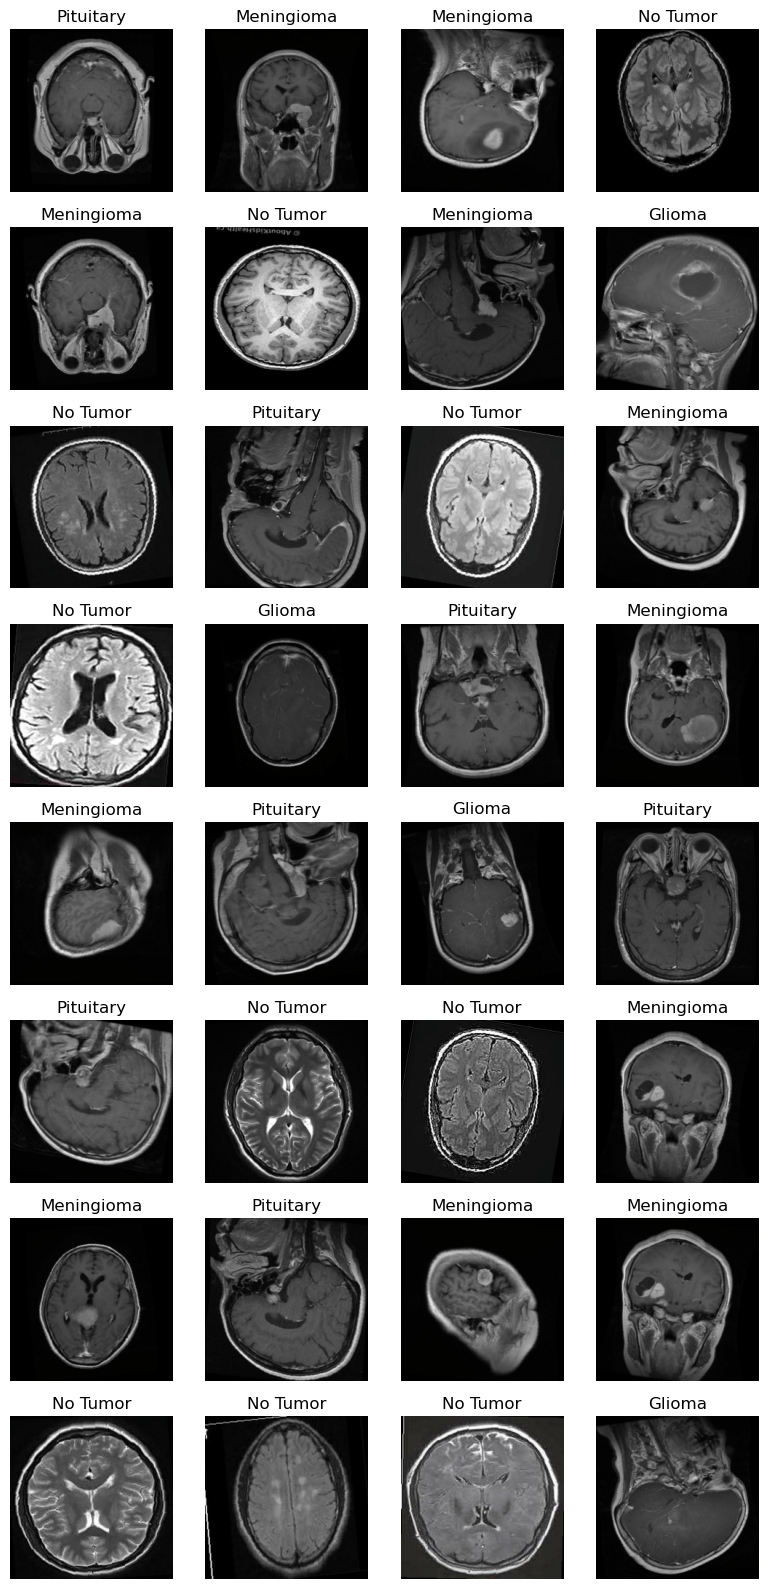

In [17]:
train_iter = iter(train_loader)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"notumor":"No Tumor", "glioma":"Glioma", "meningioma":"Meningioma","pituitary":"Pituitary"}
    input_images=input_images.numpy().transpose((0,2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()


imshow(images, labels_indices,labels)


In [18]:
class Model(nn.Module):
    def __init__(self,num_classes):
        super(Model,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
num_classes = 5
model = Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inpl

In [20]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
       
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [21]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [22]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Retraining 40 more Epochs after an initial 20 epochs

In [23]:
best_score = float("inf")
n_epochs = 40
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"newmodel_{epoch+1}.pth")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 20:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

Epoch 0,   Batch 150/179, Loss: 0.5862, Accuracy: 77.36%
Train Loss: 0.5565, Train Accuracy: 78.73%
Eval Loss: 0.5685, Eval Accuracy: 77.56%
######################################################################
Epoch 1,   

KeyboardInterrupt: 

In [ ]:
def test_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(test_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [ ]:
avg_test_loss, test_accuracy = test_model()
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.0451, Test Accuracy: 99.24%


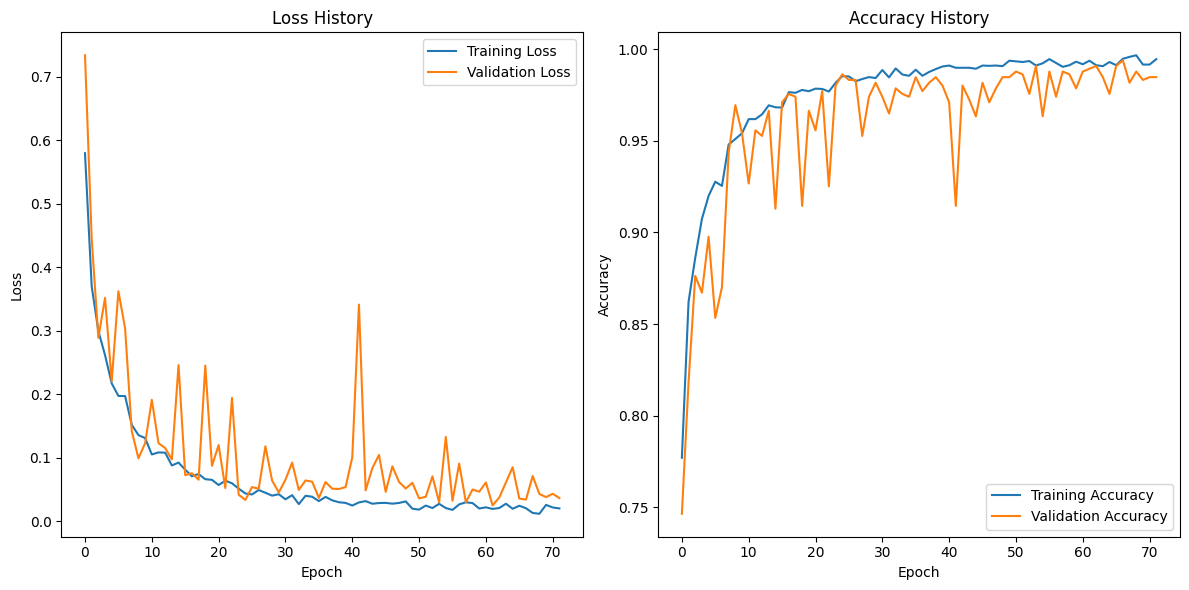

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [ ]:
best_model_path = 'C:\ML Projects\DiseaseForecasterApp-main1\DiseaseForecasterApp-main\modelweights\newmodel_30.pth'


'/kaggle/working/newmodel_30.pth'

In [ ]:
best_model = Model(num_classes).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))

<All keys matched successfully>

In [ ]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [ ]:
best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)

In [ ]:
gen_labels_test_set = [label[1] for label in test_dataset]

In [ ]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 99.7%


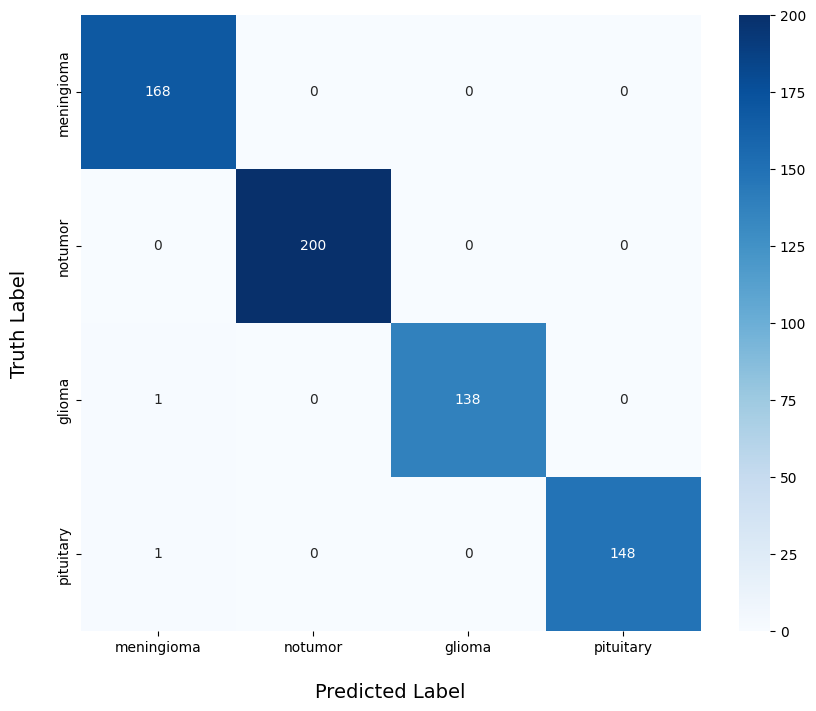

In [ ]:
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

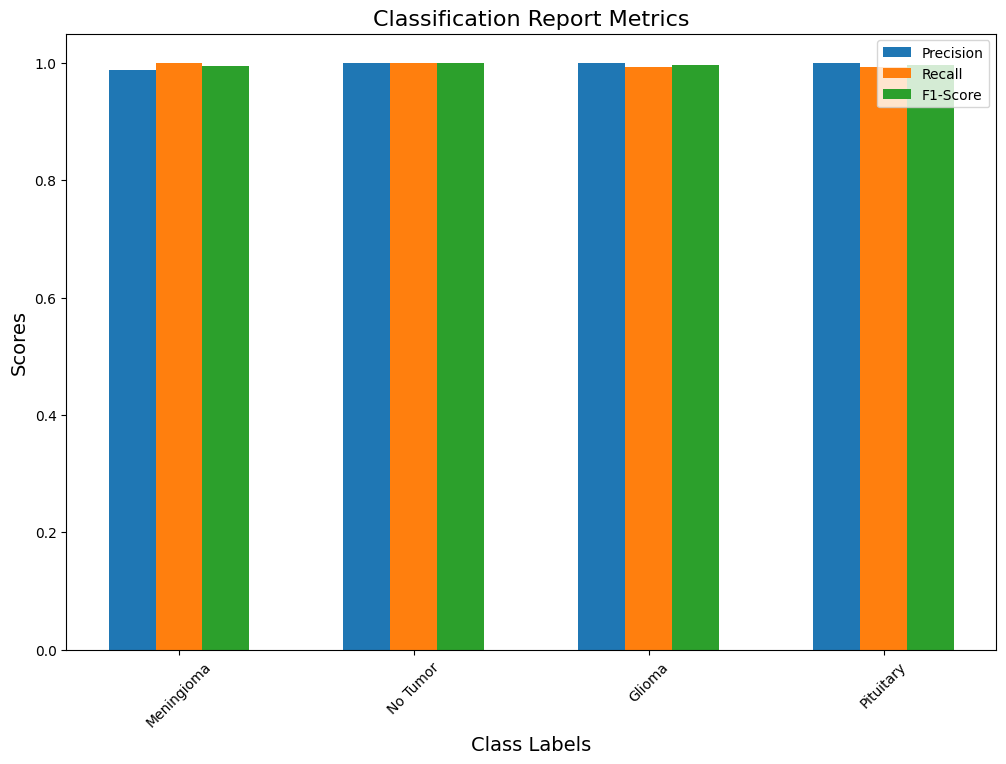

In [ ]:
label_dict = {"meningioma": "Meningioma","notumor": "No Tumor", "glioma": "Glioma", "pituitary": "Pituitary"}

class_labels = list(label_dict.values())
report = classification_report(gen_labels_test_set, best_model_preds,target_names=class_labels, output_dict=True)


precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

x = np.arange(len(class_labels))
width = 0.2

plt.figure(figsize=(12, 8))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Classification Report Metrics', fontsize=16)
plt.xticks(x, class_labels, rotation=45)
plt.legend()
plt.show()

In [ ]:

print("Classification Report (Test) -->\n")


for class_name, metrics in report.items():
    if class_name in ['accuracy', 'macro avg', 'weighted avg']:
        
        continue
    
    print(f'{class_name}:\n')
    
    print(f"  Precision: {metrics['precision']:.2f}")
    print(f"  Recall: {metrics['recall']:.2f}")
    print(f"  F1-Score: {metrics['f1-score']:.2f}")
    print(f"  Support: {metrics['support']}\n")
    
print(f"Accuracy: {report['accuracy']:.2f}")
print(f"Macro Avg Precision: {report['macro avg']['precision']:.2f}")
print(f"Macro Avg Recall: {report['macro avg']['recall']:.2f}")
print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.2f}")
print(f"Macro Avg Support: {report['macro avg']['support']}")
print(f"Weighted Avg Precision: {report['weighted avg']['precision']:.2f}")
print(f"Weighted Avg Recall: {report['weighted avg']['recall']:.2f}")
print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.2f}")
print(f"Weighted Avg Support: {report['weighted avg']['support']}")


Classification Report (Test) -->

0:

  Precision: 0.99
  Recall: 1.00
  F1-Score: 0.99
  Support: 168

1:

  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  Support: 200

2:

  Precision: 1.00
  Recall: 0.99
  F1-Score: 1.00
  Support: 139

3:

  Precision: 1.00
  Recall: 0.99
  F1-Score: 1.00
  Support: 149

Accuracy: 1.00
Macro Avg Precision: 1.00
Macro Avg Recall: 1.00
Macro Avg F1-Score: 1.00
Macro Avg Support: 656
Weighted Avg Precision: 1.00
Weighted Avg Recall: 1.00
Weighted Avg F1-Score: 1.00
Weighted Avg Support: 656


Testing on Unseen Images

In [ ]:
image_path = '/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor/P_101_VF_.jpg'  
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])
input_tensor = preprocess(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)
model.eval()  
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)  

predicted_label = class_labels[predicted.item()]  
print("Predicted Label:", predicted_label)
actual_label = "Pituitary" 
print("Actual Label:", actual_label)


Predicted Label: Pituitary
Actual Label: Pituitary
